In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def get_proteins_triv_name(proteins):
    human_proteome = pd.read_csv('../data/human_proteome.gz')
    human_proteome['accession'] = human_proteome['accession'].apply(
        lambda x: x.split('_')[0])
    names = []
    for protein in proteins:
        if protein in human_proteome['accession'].values:
            m = human_proteome.loc[human_proteome['accession']
                                   == protein]['trivname'].values
            assert len(m) == 1
            m = m[0].split('_')[0]
        else:
            m = protein
        names.append(m)
    return names


In [8]:
dataset = "sepsis"
protein_from_what_analysis = "weighed"
save = True


In [6]:
if dataset == "covid":
    df = pd.read_csv("../data/ms/covid/AaronQM.tsv", sep="\t")
    design = pd.read_csv("../data/ms/covid/design_cropped.tsv", sep="\t")
    sample_col = "sample"
    samples1 = design[design['group'] == 1][sample_col].values.tolist()
    samples2 = design[design['group'] == 2][sample_col].values.tolist()
    top_proteins_DE = ['CRP', 'PIGR', 'SAA2', 'SAA1', 'CXCL7', 'LBP', 'PEDF', 'CYTC',
       'ITIH4', 'ZA2G', 'A2GL', 'AMBP', 'HEMO', 'TSP1', 'GELS', 'APOE',
       'CO9', 'LV301', 'S10A8', 'PCOC1']
    top_proteins_residual = ['FIBA', 'VTNC', 'GELS', 'FIBB', 'FA9', 'LV657', 'CO3', 'CFAH', 'IGKC',
                             'CO9', "KVD20", 'LV208', 'ZA2G', 'KV401', 'A2MG', 'SAA1', 'LV743', 'HV102', 'LBP', 'CD14']
    weighed_by_log_SG = ['ZA2G',  'VTNC',  'CFAH',  'GELS',  'CO9',  'FIBA',  'FA9',  'FIBB',  'C4BPA',
                         'LBP',  'CO3',  'A2MG',  'CO8G',  'HRG',  'LV657',  'IGKC',  'SAMP',  'KVD20',  'LV208',  'CXCL7']
    epochs10 = ['GELS', 'FIBA', 'CO3', 'PLF4', 'S10A8', 'APOE', 'APOA4', 'FIBB', 'ZA2G', 'TSP1',
                'FA9', 'CD14', 'CYTC', 'THRB', 'APOA1', 'LV208', 'LV657', 'KVD20', 'IGKC', 'HV102']
    epochs10_weighted = ['ZA2G', 'GELS', 'PLF4', 'CO3', 'APOA4', 'S10A8', 'FIBA', 'CYTC', 'RNAS1',
                         'APOE', 'FA9', 'TSP1', 'FIBB', 'CD14', 'ANT3', 'CO8G', 'THRB', 'VTNC', 'CO9', 'APOA1']
    epochs5 = ['GELS', 'TSP1', 'APOE', 'FIBA', 'PLF4', 'CO3', 'ZA2G', 'APOA1', 'S10A8', 'FIBB',
               'CD14', 'APOA4', 'THRB', 'RNAS1', 'APOB', 'ANGT', 'LV325', 'ADIPO', 'FETUA', 'FA9']
    epochs5_weighted = ['GELS', 'ZA2G', 'TSP1', 'RNAS1', 'APOE', 'PLF4', 'FIBA', 'S10A8', 'CO3',
                        'ADIPO', 'APOA4', 'APOA1', 'CD14', 'THRB', 'ANGT', 'FIBB', 'FETUA', 'FA9', 'CAH2', 'LV325']
elif dataset == "sepsis":
    df = pd.read_csv("../data/ms/sepsis/QuantMatrix.csv")
    sample_col = "sample"
    design = pd.read_csv("../data/ms/sepsis/inner_design_matrix.tsv", sep="\t")
    samples1 = design[design['group'] == 1][sample_col].values.tolist()
    samples2 = design[design['group'] == 2][sample_col].values.tolist()
    top_proteins_residual = ['APOB', 'CD14', 'FA10', 'CALR', 'ANT3', 'APOA4', 'APOA1', 'HV353', 'THRB',
                             'CSPG2', 'KV320', 'ACTB', 'ITIH2', 'HV323', 'HBB', 'KVD40', 'KNG1', 'MMP9', 'IGHD', 'LV743']
    top_proteins_DE = ['DEF1', 'ICAM1', 'CD14', 'B2MG', 'CD44', 'PYGL', 'C163A', 'FCG3A', 'PEDF',
                       'LYAM1', 'PSA5', 'B4GT1', 'C1RL', 'NGAL', 'GFAP', 'IBP4', 'G6PI', 'PSB6', 'VCAM1', 'CYTC']
    top_XGB = ["DEF1", 'ICAM1', 'CD44', 'CD14',
               'APOA4', 'CATZ', 'NGAL', 'ALS', 'LYSC', 'IGHD']
    weighed_by_log_SG = ['APOB',  'CD14',  'CALR',  'HV323',  'CATZ',  'APOA4',  'APOA1',  'ACTB',  'HV353',
                         'FA10',  'KNG1',  'HBB',  'THRB',  'ANT3',  'KV320',  'CO1A1',  'RNAS1',  'LV321',  'OSTP',  'KVD40']
    epochs20_weighted= ['APOB', 'CD14', 'CALR', 'FA10', 'KNG1', 'APOA4', 'CO1A1', 'APOA1', 'ANT3', 'OSTP', 'THRB', 'ACTB', 'HBB', 'RNAS1', 'HSP7C', 'ITIH2', 'CATZ', 'CSPG2', 'ADH1A', 'GOLM1']
    epochs10 = ['H2A1B', 'APOB', 'H2B1A', 'CALR', 'CD14', 'ACTB', 'APOA1', 'THRB', 'CO1A1',
                'FA10', 'APOA4', 'H4', 'HS90A', 'CATZ', 'HBB', 'RNAS1', 'HV353', 'PON1', 'HS90B', 'ITB3']
    epochs10_weighted = ['CALR', 'H2A1B', 'APOB', 'CD14', 'RNAS1', 'H2B1A', 'FA10', 'APOA4', 'ACTB',
                         'APOA1', 'THRB', 'CO1A1', 'CATZ', 'PON1', 'HBB', 'H4', 'HS90A', 'RETN', 'APOC3', 'K22E']
    epochs5_weighted = ['APOB', 'RNAS1', 'APOA1', 'FA10', 'CD14', 'CO1A1', 'ACTB', 'HBB', 'CALR',
                        'APOA4', 'CATZ', 'CSPG2', 'B4GT1', 'B2MG', 'ITB3', 'HS90B', 'THRB', 'PSPB', 'PTGDS', 'H2B1A']
    epochs5 = ["APOB", "APOA1", "ACTB", "CO1A1", "FA10", "CD14", "RNAS1", "HBB",
               "H2B1A", "CALR", "HS90B", 'ITB3', 'APOA4', 'B2MG', 'B4GT1', 'CSPG2', 'H4']

if protein_from_what_analysis == "residual":
    top_proteins = top_proteins_residual
elif protein_from_what_analysis == "DE":
    top_proteins = top_proteins_DE
elif protein_from_what_analysis == "weighed":
    top_proteins = epochs20_weighted

df['Protein'] = get_proteins_triv_name(df['Protein'])

top_df = df[df['Protein'].isin(top_proteins)]
top_df.set_index('Protein', inplace=True)
top_df = top_df.loc[top_proteins]
top_df = top_df[samples1+samples2].T

X = top_df.fillna(0).to_numpy()
cols = top_df.columns
ind = top_df.index
X_scaled = StandardScaler().fit_transform(X)
top_df = pd.DataFrame(X, columns=cols, index=ind)
top_df_scaled = pd.DataFrame(X_scaled, columns=cols, index=ind)
top_df


Protein,APOB,CD14,CALR,FA10,KNG1,APOA4,CO1A1,APOA1,ANT3,OSTP,THRB,ACTB,HBB,RNAS1,HSP7C,ITIH2,CATZ,CSPG2,ADH1A,GOLM1
TM_M2012_010,21.365600,19.625224,0.000000,19.402992,22.963205,23.408347,0.000000,26.020014,23.020617,0.000000,22.292130,20.682322,23.773150,18.292955,19.136238,22.973576,0.000000,0.000000,0.000000,0.000000
TM_M2012_011,20.709190,19.588420,0.000000,20.077578,22.767097,21.904422,21.985098,24.802431,22.303284,0.000000,22.834217,19.905688,22.218446,17.523342,19.278868,22.408690,0.000000,0.000000,0.000000,0.000000
TM_M2012_012,21.567171,20.152802,0.000000,20.378783,22.947755,21.635674,21.969398,24.894461,22.443245,0.000000,22.764523,19.701901,22.504397,18.162075,18.942427,22.596042,0.000000,0.000000,0.000000,0.000000
TM_M2012_013,22.253342,20.558064,0.000000,20.976831,23.341073,21.719163,20.255343,24.791341,22.743177,0.000000,23.230437,20.446986,22.664706,18.127471,18.270571,23.106574,0.000000,0.000000,15.822559,16.912560
TM_M2012_014,22.219388,20.392815,0.000000,20.782373,23.321479,21.564217,18.672364,24.272220,22.525652,0.000000,23.262083,20.026559,21.771843,18.349076,18.546042,22.803972,0.000000,0.000000,16.487399,16.596790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TM_M2012_198,23.009422,22.445482,23.503876,21.059654,23.471356,23.531707,23.052132,26.376594,22.427175,20.308079,23.045147,25.264425,27.953704,20.684502,22.395366,23.209810,20.421314,20.740990,26.183970,19.896401
TM_M2012_199,23.034133,22.632111,23.676422,20.737350,23.471414,24.604203,22.287651,26.669582,22.930680,20.766631,23.236354,25.105313,27.248864,21.164447,22.538457,23.206802,20.804875,21.456883,26.780947,19.663386
TM_M2012_200,23.295811,22.417214,23.131690,20.716582,23.193750,25.344956,21.628394,26.319480,22.505519,20.508094,23.068883,24.964861,27.635005,21.680267,21.485685,23.130188,19.139559,21.271412,25.297639,20.074849
TM_M2012_202,23.844134,21.757771,21.966376,22.400365,24.101306,24.817844,17.903092,24.743276,23.163266,19.619662,23.470422,22.795831,23.908218,22.537867,20.096506,23.247435,19.505958,19.861667,20.837485,18.666779


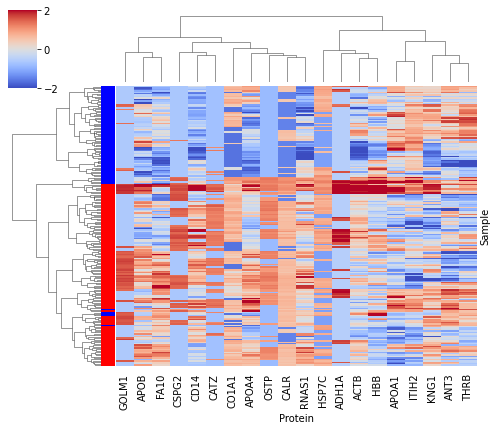

In [9]:
def get_sample_group(samples1, samples2, x):
    if x in samples1:
        return 1
    else:
        return 2


group = [get_sample_group(samples1, samples2, x) for x in top_df_scaled.index]
my_palette = dict(zip([1, 2], ["blue", "red"]))
row_colors = pd.Series(group).map(my_palette)

g = sns.clustermap(top_df_scaled, method='ward', metric="euclidean", 
                   vmin=-2, vmax=2,  row_colors=row_colors.to_numpy(), figsize=(8, 6), cmap="coolwarm")
g.ax_heatmap.tick_params(left=False, bottom=False, right=False)
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_ylabel("Sample")

if save:
    plt.savefig(
        f'../plots/manuscript/{dataset}_clustmap_{protein_from_what_analysis}.svg', bbox_inches="tight", dpi=300)


0.9031389205428364

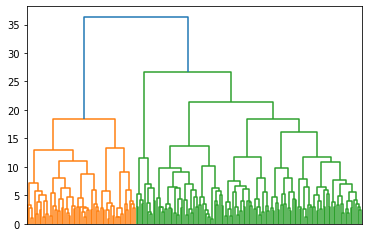

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from sklearn import metrics


linkage_data = linkage(top_df_scaled, method='ward', metric='euclidean')
d = dendrogram(linkage_data,  labels=top_df.index, color_threshold=35)
plt.xticks([])
clust_samples = [i for i in d['ivl']]
d_zip = pd.DataFrame(
    {'index': d['leaves'], 'color': d['leaves_color_list'], sample_col: clust_samples})
d_zip = d_zip.merge(design, on="sample")

d_zip['cluster'] = d_zip['color'].map({'C1': 1, 'C2': 2})

label_pred = d_zip['cluster']
label_true = d_zip['group']
metrics.rand_score(label_true, label_pred)


/tmp/ipykernel_6912/3119492918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X['label'] = group


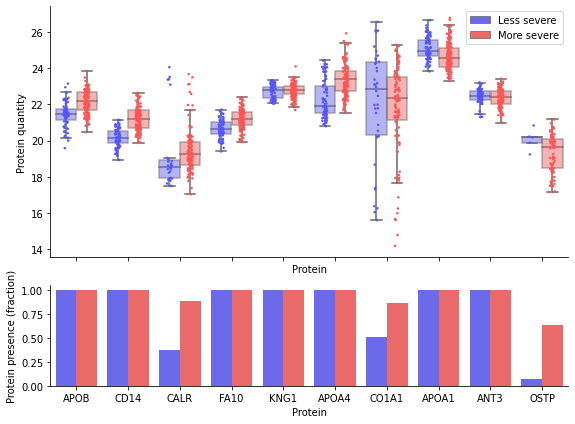

In [11]:
df_X = top_df[top_proteins[0:10]]
df_X['label'] = group

group_1 = df_X[df_X['label'] == 1]
group_1 = group_1[top_proteins[0:10]]
group_2 = df_X[df_X['label'] == 2]
group_2 = group_2[top_proteins[0:10]]
group_1 = pd.DataFrame(group_1.unstack()).reset_index()
group_1['group'] = "Less severe"

group_1.rename(columns={'level_0': 'Protein', "0": 'quant'}, inplace=True)

group_2 = pd.DataFrame(group_2.unstack()).reset_index()
group_2['group'] = "More severe"
group_2.rename(columns={'level_0': 'Protein', "0": 'quant'}, inplace=True)

new_df = pd.concat([group_1, group_2])
new_df = new_df[['Protein', 0, 'group']]
new_df = new_df[new_df[0] != 0]


figure, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={
                           'height_ratios': [2.5, 1]}, sharex=True)
ax = sns.boxplot(data=new_df, x="Protein", y=0, hue='group', ax=axs[0], boxprops=dict(
    alpha=.5), zorder=.5, fliersize=False, palette="seismic")
handles, labels = ax.get_legend_handles_labels()
sns.stripplot(data=new_df, x="Protein", y=0, hue='group',
              ax=axs[0], size=2.5, dodge=True,  palette="seismic")
# Remove the old legend

new_df['count'] = 1

grouped_df = new_df.groupby(['Protein', 'group'], as_index=False).sum()
grouped_df['count'] = grouped_df.apply(lambda x: x['count'] / len(
    samples1) if x['group'] == 'Less severe' else x['count'] / len(samples2), axis=1)
grouped_df.set_index('Protein', inplace=True)
grouped_df = grouped_df.loc[top_proteins[0:10]]
grouped_df.reset_index(inplace=True)
sns.barplot(data=grouped_df, x='Protein', y='count',
            ax=axs[1], hue='group', palette="seismic")

for ax in axs.ravel():
    ax.legend_.remove()
    # Add just the handles/labels from the box plot back
for ax in axs.ravel():
    ax.legend(
        handles,
        labels,
        loc=0,
    )
    break
axs[0].set_ylabel('Protein quantity')
axs[1].set_ylabel('Protein presence (fraction)')
plt.xlabel('Protein')
plt.tight_layout()
sns.despine()
if save:
    plt.savefig(
        f'../plots/manuscript/{dataset}_proteinBoxplot_{protein_from_what_analysis}.svg', dpi=300)


In [12]:

df = pd.read_csv("../data/ms/sepsis/QuantMatrix.csv")
sample_col = "sample"
design = pd.read_csv("../data/ms/sepsis/inner_design_matrix.tsv", sep="\t")
samples1 = design[design['group'] == 1][sample_col].values.tolist()
samples2 = design[design['group'] == 2][sample_col].values.tolist()
MHC_proteins = ["APOB", "APOA1", "APOA4", "APOC2", "APOC3",
                "APOE", "APOA", "APOF", "PDIA1", "APOA2", "ALBU", "LCAT"]

df['Protein'] = get_proteins_triv_name(df['Protein'])
top_df = df[df['Protein'].isin(MHC_proteins)]
top_df.set_index('Protein', inplace=True)
top_df = top_df.loc[MHC_proteins]
top_df = top_df[samples1+samples2].T

X = top_df.fillna(0).to_numpy()
cols = top_df.columns
ind = top_df.index
# X= impute_uni(X)

X_scaled = StandardScaler().fit_transform(X)
X_scaled = np.clip(X_scaled, -2, 2)
top_df = pd.DataFrame(X, columns=cols, index=ind)
top_df_scaled = pd.DataFrame(X_scaled, columns=cols, index=ind)
top_df


Protein,APOB,APOA1,APOA4,APOC2,APOC3,APOE,APOA,APOF,PDIA1,APOA2,ALBU,LCAT
TM_M2012_010,21.365600,26.020014,23.408347,22.975607,26.353944,22.168855,21.042081,22.217762,0.000000,25.974645,25.664520,20.213749
TM_M2012_011,20.709190,24.802431,21.904422,22.340578,24.404013,21.071163,24.320359,23.090797,16.874176,25.520950,25.342843,20.143494
TM_M2012_012,21.567171,24.894461,21.635674,23.080529,24.711845,21.603873,24.657102,23.165706,0.000000,26.294813,25.447524,20.272817
TM_M2012_013,22.253342,24.791341,21.719163,23.669245,25.387981,22.178345,24.620349,23.285347,0.000000,25.126798,25.537691,20.647173
TM_M2012_014,22.219388,24.272220,21.564217,23.562359,25.458391,22.019633,24.461357,23.120037,16.697074,25.781662,25.442052,20.447291
...,...,...,...,...,...,...,...,...,...,...,...,...
TM_M2012_198,23.009422,26.376594,23.531707,24.708806,26.710258,23.620709,25.708521,23.941166,22.311730,22.750944,25.977094,21.466134
TM_M2012_199,23.034133,26.669582,24.604203,25.031899,26.546766,24.035871,25.580399,23.753857,22.842538,27.366162,25.879301,21.505466
TM_M2012_200,23.295811,26.319480,25.344956,25.447930,26.679368,24.614106,25.626496,20.725738,21.665472,24.302809,25.801212,20.858845
TM_M2012_202,23.844134,24.743276,24.817844,24.820853,26.701645,25.222972,23.849869,23.002575,19.314706,22.349927,25.815368,20.896960


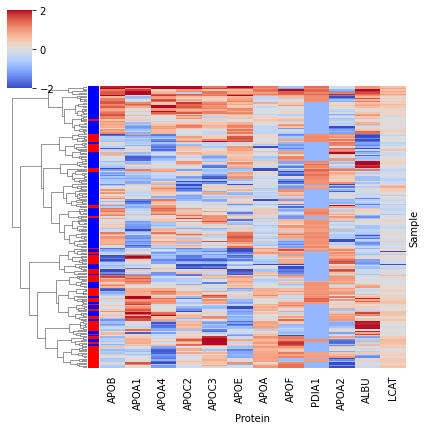

In [13]:
def get_sample_group(samples1, samples2, x):
    if x in samples1:
        return 1
    else:
        return 2


group = [get_sample_group(samples1, samples2, x) for x in top_df_scaled.index]
my_palette = dict(zip([1, 2], ["red", "blue"]))
row_colors = pd.Series(group).map(my_palette)

g = sns.clustermap(top_df_scaled, method='ward', col_cluster=False, metric='euclidean',
                   vmin=-2, vmax=2, row_colors=row_colors.to_numpy(), figsize=(7, 6), cmap="coolwarm")
g.ax_heatmap.tick_params(left=False, bottom=False, right=False)
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_ylabel("Sample")
plt.savefig(f'../plots/manuscript/network/{dataset}_heatmap_lipo.svg', dpi=300)
